# Tips & Trics for anypytools

## Stopping and restarting simulations

AnyPyProcess caches the simulation results. This allows us to stop the simulations, and then later restart them again.

In [2]:
from anypytools.abcutils import AnyPyProcess 
app = AnyPyProcess(num_processes=1, return_task_info = True )
macro = [['load "Knee.any"', 
          'operation Main.MyStudy.InverseDynamics',
          'run']]*20

In [3]:
app.start_macro(macro); 

[*****************85%************      ]  17 of 20 complete

Here we stopped the simulation using the Notebook interrupt button. Calling the `start_macro()` function again continues the processing and re-run any task that wasn't completed in the first run and any task that exited with errors. 

In [4]:
app.start_macro(macro);

[****************100%******************]  20 of 20 complete

Note: That changing the input arguments `start_macro` or re-instanciating the the `app` object will erase the cache and re-run all processes. 

## Including meta-information in the output

The typical behaviour of `start_macro()` is to only return variables 'dump'ed by the macro commands. 

In [5]:
from anypytools.abcutils import AnyPyProcess 

app = AnyPyProcess()
macro = [['load "Knee.any" -def N_STEP="10"', 
          'operation Main.MyStudy.InverseDynamics',
          'classoperation Main.MyStudy.Output.MaxMuscleActivity "Dump"',
          'run']]
app.start_macro(macro)

[****************100%******************]  1 of 1 complete

[{'Main.MyStudy.Output.MaxMuscleActivity': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}]

To get more informatin about the tasks, we can set `return_task_info` flag. 

In [6]:
from anypytools.abcutils import AnyPyProcess 

app = AnyPyProcess(return_task_info = True)
macro = [['load "Knee.any" -def N_STEP="10"', 
          'operation Main.MyStudy.InverseDynamics',
          'classoperation Main.MyStudy.Output.MaxMuscleActivity "Dump"',
          'run']]
app.start_macro(macro) 

[****************100%******************]  1 of 1 complete

[{'Main.MyStudy.Output.MaxMuscleActivity': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'task_macro_hash': 2122630419,
  'task_id': 0,
  'task_work_dir': 'E:\\Users\\MEL\\GitHub\\AnyPyTools\\Tutorial',
  'task_name': 'AnyPyTools/Tutorial_0',
  'task_processtime': 0.45403020131006855,
  'task_macro': 
    ['load "Knee.any" -def N_STEP="10"',
     'operation Main.MyStudy.InverseDynamics',
     'classoperation Main.MyStudy.Output.MaxMuscleActivity "Dump"',
     'run'],
  'task_logfile': u''}]

That returns extra meta information about the processing and the macros... 

## Saving output to re-process at a later time

Saving data with 'extra' task information, gives some extra options. The output from `start_macro` can be used as input to restart the same processing even if the AnyPyProcess have no cached results. 

In [7]:
from anypytools.abcutils import AnyPyProcess 

app = AnyPyProcess(return_task_info = True)
macro = [['load "Knee.any" -def N_STEP="10"', 
          'operation Main.MyStudy.InverseDynamics',
          'classoperation Main.MyStudy.Output.MaxMuscleActivity "Dump"',
          'run']]
output = app.start_macro(macro) 

[****************100%******************]  1 of 1 complete

In [8]:
app = AnyPyProcess()
app.start_macro(output)

[****************100%******************]  1 of 1 complete

[{'Main.MyStudy.Output.MaxMuscleActivity': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'task_macro_hash': 2122630419,
  'task_id': 0,
  'task_work_dir': 'E:\\Users\\MEL\\GitHub\\AnyPyTools\\Tutorial',
  'task_name': 'AnyPyTools/Tutorial_0',
  'task_processtime': 0.5042249194407731,
  'task_macro': 
    ['load "Knee.any" -def N_STEP="10"',
     'operation Main.MyStudy.InverseDynamics',
     'classoperation Main.MyStudy.Output.MaxMuscleActivity "Dump"',
     'run'],
  'task_logfile': u''}]

The effect is that the result of an analysis can be saved to files and later restarted.  The next example illustrates this.

## Example: Saving data to disk while running

In [9]:
import os
from scipy.stats import distributions
from anypytools.abcutils import AnyPyProcess, AnyMacro
from anypytools.macro_commands import Load, SetValue_random, OperationRun, Dump

In [13]:

tibia_knee_srel = distributions.norm([0, 0.18, 0], [0.005, 0.005, 0.005] ) 
femur_knee_srel = distributions.norm([0, -0.3, 0], [0.005, 0.005, 0.005] ) 

app = AnyPyProcess(return_task_info=True, disp=False)
mg = AnyMacro(number_of_macros = 500)
mg.extend([
    Load('knee.any', defs = {'N_STEP':20}),
    SetValue_random('Main.MyModel.Tibia.Knee.sRel', tibia_knee_srel ),
    SetValue_random('Main.MyModel.Femur.Knee.sRel',femur_knee_srel   ),
    OperationRun('Main.MyStudy.InverseDynamics'),
    Dump('Main.MyStudy.Output.MaxMuscleActivity')
])

try:
    os.remove('data.db')
except OSError:
    pass

for macros in mg.create_macros_MonteCarlo(batch_size=50):
    app.start_macro(macros)
    app.save_results('data.db', append=True)
    print('Data saved')
print('Done')

Data saved
Data saved
Data saved
Data saved
Data saved
Data saved
Data saved
Data saved
Data saved
Data saved
Done


All this stored data can be be reloaded 

In [14]:
reloaded_results = app.load_results('data.db')
print('Entries in file: ' + str( len(reloaded_results)) ) 

Entries in file: 500


In [15]:
reloaded_results[456:457]

[{'Main.MyStudy.Output.MaxMuscleActivity': 
    array([ 0.00819457,  0.01214672,  0.0214819 ,  0.03533908,  0.05148713,
            0.06591192,  0.07449962,  0.07807253,  0.08020784,  0.08028192,
            0.08028204,  0.08020768,  0.07807253,  0.07449961,  0.06591191,
            0.05148713,  0.03533908,  0.02148197,  0.01214666,  0.00819457]),
  'task_macro_hash': -1836739521,
  'task_id': 6,
  'task_work_dir': 'E:\\Users\\MEL\\GitHub\\AnyPyTools\\Tutorial',
  'task_name': 'AnyPyTools/Tutorial_6',
  'task_processtime': 0.65817032156491,
  'task_macro': 
    [u'load "knee.any" -def N_STEP="20"',
     u'classoperation Main.MyModel.Tibia.Knee.sRel "Set Value" --value="{-0.000101703007497,0.179435475933,0.000832609912988}"',
     u'classoperation Main.MyModel.Femur.Knee.sRel "Set Value" --value="{0.00255770447959,-0.296398679719,-0.000193252474793}"',
     u'operation Main.MyStudy.InverseDynamics',
     u'run',
     u'classoperation Main.MyStudy.Output.MaxMuscleActivity "Dump"'],
  'ta

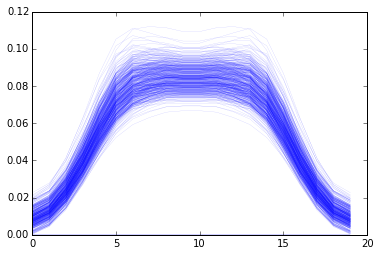

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(reloaded_results['MaxMuscleAct'].T, 'b', lw=0.2, alpha = 0.3);